In [164]:
# default_exp loaders

# Datasets, DataLoaders, Samplers

In [165]:
# export

from pathlib import Path

import random
import numpy as np
import pandas as pd
from natsort import natsorted
import copy

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform

In [166]:
# export
from lunglens.core import *
from lunglens.data import *

### Custom Augmentations

In [167]:
# export
def np_to_rgb_tensor(img):
    # add new dimention to get C x H x W
    # repeat color to get RBB
    rgb_image = np.repeat(img[np.newaxis, ...], 3, axis=0)
    return torch.FloatTensor(rgb_image)

# custom albumentation transformer
class ToColorTensor(ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1):
        super().__init__(always_apply, p)
        
    def apply(self, img, **params):
        return np_to_rgb_tensor(img)

def img_tfm(tfm):
    return lambda img: tfm(image=img)['image']

In [168]:
datasets_root = Path('../data/prepared')
all_slices = list(datasets_root.rglob('*.npy'))
len(all_slices)

55116

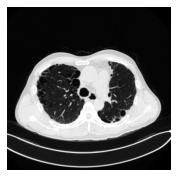

In [169]:
random_img_path = random.choice(all_slices)
random_img_path = '../data/prepared/osic-pulmonary-fibrosis-progression/ID00388637202301028491611/192.npy'
random_img = np.load(str(random_img_path))
print_slice(random_img, figsize=(3,3))

In [170]:
tfm = img_tfm(ToColorTensor())
rgb_img = tfm(random_img)
rgb_img.shape

torch.Size([3, 400, 400])

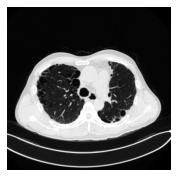

In [171]:
print_slice(rgb_img[0], figsize=(3,3))

## Basic dataset for Contrastive Learning

Generates specified number of slices from one scans per one item. Length of the dataset is equal to the number of scans

In [172]:
# export

class RandomSlicerDataset(Dataset):
    def __init__(self, datasets_root, transform=None, slices_per_scan=4, inter_slice_distance=8):
        scans = list(Path(datasets_root).glob('*/*'))
        #
        # remove from list scans with insufficient number of slices
        self.slices_cache = {}
        for scan_dir in scans:
            slices_files = natsorted(map(str, scan_dir.glob('*.npy')))
            if len(slices_files) > slices_per_scan * inter_slice_distance:
                self.slices_cache[scan_dir] = np.array(slices_files)
            else:
                scans.remove(scan_dir)
        #
        tst_idx = list(range(2, len(scans), 5))
        self.tst_scans = [scans[i] for i in tst_idx]
        trn_idx = set(tst_idx).symmetric_difference(list(range(len(scans))))
        self.trn_scans = [scans[i] for i in trn_idx]
        self.mode = 'trn'
        self.scans = self.trn_scans
        #
        self.consistant_slices = False
        #
        self.transform = transform
        self.slices_per_scan = slices_per_scan
        self.inter_slice_distance = inter_slice_distance
        
        #self.slices_cache = {}

    def set_trn_mode(self):
        self.mode = 'trn'
        self.scans = self.trn_scans
        self.consistant_slices = False

    def set_tst_mode(self):
        self.mode = 'tst'
        self.scans = self.tst_scans
        self.consistant_slices = True


    def __len__(self):
        return len(self.scans)

    def __getitem__(self, idx):
        # idx can be an indexing slice or an index
        if isinstance(idx, slice):
            idx_range = range(len(self))[idx]
            
            return [self.get_item(idx) for idx in idx_range]
        else:
            return self.get_item(idx)
    
    def get_item(self, idx):
        scan_dir = self.scans[idx]

        if str(scan_dir) not in self.slices_cache:
            slices_files = map(str, scan_dir.glob('*.npy'))

            # natural sorting of files
            self.slices_cache[scan_dir] = np.array(natsorted(slices_files))

        slices_files = self.slices_cache[scan_dir]

        # calculate num of combinations based on total items count, return count and step size
        combinations_n = len(slices_files) - self.inter_slice_distance * (self.slices_per_scan - 1)

        # retrun slices according to config
        idx_first_slice = np.random.randint(combinations_n) if not self.consistant_slices \
            else np.array([ord(c) for c in scan_dir.__str__()]).sum() % combinations_n
        idx_list = idx_first_slice + self.inter_slice_distance * np.arange(self.slices_per_scan)

        random_slices = lmap(np.load, slices_files[idx_list])

        # augment two copies of selected random files
        return self.aug(random_slices), self.aug(random_slices)

    def aug(self, slices):
        if self.transform:
            slices = lmap(self.transform, slices)

        # return np.stack(slices)
        w, h = slices[0].shape
        return np.stack(slices).reshape((len(slices), 1, w, h)).astype(np.float32)



In [173]:
# this just an example
tfms = img_tfm(A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(384, 384)
    #ToColorTensor()
]))

In [174]:
dataset = RandomSlicerDataset(datasets_root, transform=tfms)
len(dataset)

142

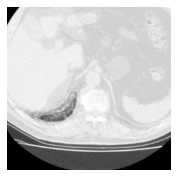

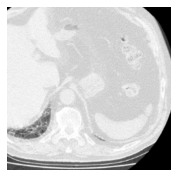

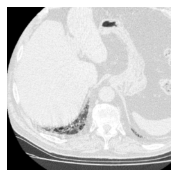

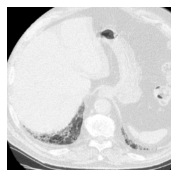

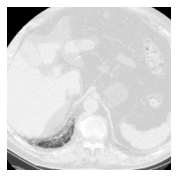

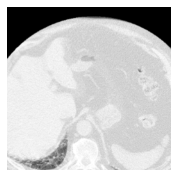

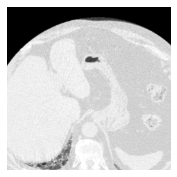

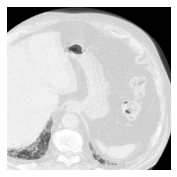

In [175]:
for slice_images in random.choice(dataset):
    for slice_img in slice_images:
        print_slice(slice_img[0], figsize=(3, 3))


#### Checking if caching is working
Enumerating the dicrectory is cached but slices loading is not because datasets are too big

In [176]:
%%time
for slices_batch in dataset[:10]:
    pass

Wall time: 554 ms


In [177]:
%%time
for slices_batch in dataset[:10]:
    pass

Wall time: 445 ms


#### Testing with default dataloader

In [178]:
batch_size = 8

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

#### Optionally we can squash per-scan batches into one batch

In [ ]:
# export

# merge list of scans batches into one batch
# [N, M, ...] -> [N * M, ...]
def squash_scan_batches(superbatch):
    shape = np.array(superbatch.shape)
    
    # slices from all scans and all batches go to single batch
    shape[1] = shape[1] * shape[0]
    
    # drop first dimension
    return superbatch.view(*shape[1:])

# split batch of slices from N scans into N per-scan batches
# [N * M, ...] -> [N, M, ...]
def split_scans(superbatch, num_scans, num_slices):
    # add extra dimension
    shape = np.array([0] + list(superbatch.shape))

    shape[:2] = [num_scans, num_slices]

    return superbatch.view(*shape)

In [ ]:
for superbatch0, superbatch1 in loader:
    break

In [ ]:
src_shape = np.array(superbatch0.shape)

src_shape

In [ ]:
reshaped_batch0 = squash_scan_batches(superbatch0)
reshaped_batch1 = squash_scan_batches(superbatch1)
print(reshaped_batch0.shape)

In [ ]:
split_scans(reshaped_batch1, src_shape[0], src_shape[1]).shape

In [ ]:
print_slice(superbatch0[0][1][0], figsize=(3, 3))
print_slice(superbatch1[0][1][0], figsize=(3, 3))
print_slice(superbatch0[1][1][0], figsize=(3, 3))
print_slice(superbatch1[1][1][0], figsize=(3, 3))

In [ ]:
print_slice(reshaped_batch0[1][0], figsize=(3, 3))
print_slice(reshaped_batch0[4 + 1][0], figsize=(3, 3))

## patch based dataset for contrastive learning

In [179]:
# export

class PatchedDataset(Dataset):
    def __init__(self, datasets_root, transform=None, \
                 patch_size=32, ext_patch_size=40, patches_per_set=24, max_num_sets=4,\
                target_size = (128, 128), minibatch_size=4):
        scans = list(Path(datasets_root).glob('*/*'))
        #
        # remove from list scans with insufficient number of slices
        self.patch_file_cache = {}
        for scan_dir in scans:
            patch_files = natsorted(map(str, scan_dir.glob('*.npy')))
            if len(patch_files) >= minibatch_size:
                self.patch_file_cache[scan_dir] = np.array(patch_files)
            else:
                print('not enough files in', scan_dir)
                scans.remove(scan_dir)
        #
        #print(len(scans), 'scans', len(self.patch_file_cache)*max_num_sets, 'patch files')
        #print(self.patch_file_cache[scans[0]])
        
        tst_idx = list(range(2, len(scans), 5))
        self.tst_scans = [scans[i] for i in tst_idx]
        trn_idx = set(tst_idx).symmetric_difference(list(range(len(scans))))
        self.trn_scans = [scans[i] for i in trn_idx]
        self.mode = 'trn'
        self.scans = self.trn_scans
        #
        self.consistant_slices = False
        #
        self.transform = transform
        # folder properties - to be read from description (yaml?) file
        self.patch_size = patch_size
        self.ext_patch_size = ext_patch_size
        self.patches_per_set = patches_per_set
        self.max_num_sets = max_num_sets
        # target properties
        self.target_size = target_size
        self.minibatch_size = minibatch_size
        #
        assert(minibatch_size <= max_num_sets)
        assert(np.prod(target_size) / (patch_size ** 2) <= patches_per_set)
        assert(target_size[0] % patch_size == 0)
        assert(target_size[1] % patch_size == 0)
        self.tiling = (int(target_size[0] / patch_size), int(target_size[1] / patch_size))
        
        self.patch_tfms = img_tfm(A.Compose([
            A.RandomCrop(patch_size, patch_size),
            A.Flip()
            #ToColorTensor()
        ]))
        
        return

        #self.slices_cache = {}

    def set_trn_mode(self):
        self.mode = 'trn'
        self.scans = self.trn_scans
        self.consistant_slices = False

    def set_tst_mode(self):
        self.mode = 'tst'
        self.scans = self.tst_scans
        self.consistant_slices = True


    def __len__(self):
        return len(self.scans)

    def __getitem__(self, idx):
        # idx can be an indexing slice or an index
        if isinstance(idx, slice):
            idx_range = range(len(self))[idx]
            
            return [self.get_item(idx) for idx in idx_range]
        else:
            return self.get_item(idx)
    
    def get_item(self, idx):
        scan_dir = self.scans[idx]

        if str(scan_dir) not in self.patch_file_cache:
            patch_files = map(str, scan_dir.glob('*.npy'))
            # natural sorting of files
            self.patch_file_cache[scan_dir] = np.array(natsorted(patch_files))

        patch_files = copy.copy(self.patch_file_cache[scan_dir])
        
        # choose files and patches
        num_patches = np.prod(self.tiling) # to create a single target
        if self.consistant_slices:
            patch_files = patch_files[:self.minibatch_size]
            patch_idx = np.tile(np.arange(num_patches), (self.minibatch_size, 1))
        else:
            patch_files = np.random.choice(patch_files, size=self.minibatch_size, replace=False)
            patch_idx = np.array([np.random.permutation(num_patches) for i in range(self.minibatch_size)])
        
        # read the patches
        patches = []
        for file_idx, patch_file in enumerate(patch_files):
            patches.append(np.load(patch_file)[patch_idx[file_idx]])
        
        #print(num_patches), print(patch_files), print(patch_idx), print(patch_idx.shape)
        return self.aug(patches), self.aug(patches)


    def aug(self, patches):

        images = np.zeros((self.minibatch_size, 1, self.target_size[0], self.target_size[1]))
        for idx_img in range(self.minibatch_size):
            order = np.random.permutation(np.prod(self.tiling))
            pidx = 0
            for i0 in range(self.tiling[0]):
                rng0 = [i0*self.patch_size, (i0+1)*self.patch_size]
                for i1 in range(self.tiling[1]):
                    rng1 = [i1*self.patch_size, (i1+1)*self.patch_size]
                    images[idx_img, 0, rng0[0]:rng0[1], rng1[0]:rng1[1]] = \
                    self.patch_tfms(patches[idx_img][order[pidx]])
                    pidx += 1
        
        return images




in tst mode (4, 1, 96, 96) (4, 1, 96, 96) 



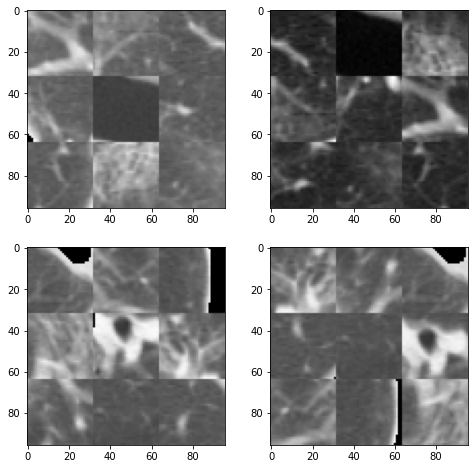

in tst mode (4, 1, 96, 96) (4, 1, 96, 96) 



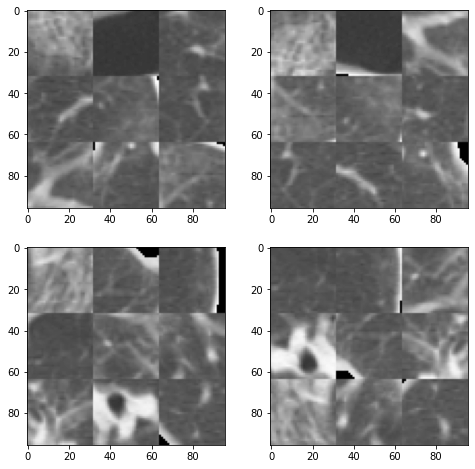

in trn mode (4, 1, 96, 96) (4, 1, 96, 96)


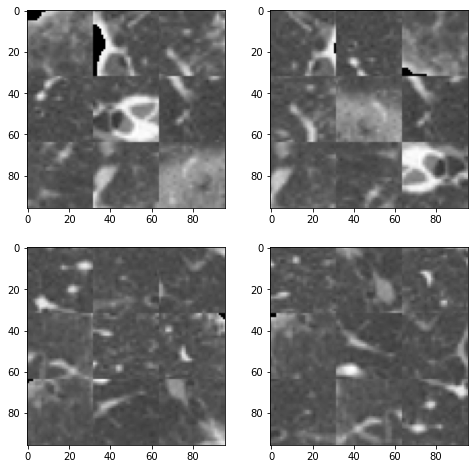

in trn mode (4, 1, 96, 96) (4, 1, 96, 96)


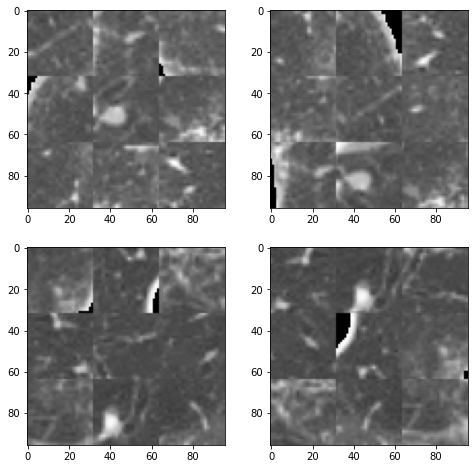

In [180]:
import matplotlib.pyplot as plt
patch_datasets_root = Path('../data/patches')
dataset = PatchedDataset(patch_datasets_root, target_size = (96, 96))
dataset.get_item(5)
dataset.set_tst_mode()
dataset.get_item(5)
for i in range(2):
    x = dataset.get_item(5)
    print('in tst mode', x[0].shape, x[1].shape, '\n')
    #print_slice(x[0][0].squeeze(), figsize=(3, 3))
    #print_slice(x[1][0].squeeze(), figsize=(3, 3))
    fig, ax = plt.subplots(2, 2, figsize=[8, 8])
    ax[0, 0].imshow(x[0][0].squeeze(), cmap='gist_gray')
    ax[0, 1].imshow(x[1][0].squeeze(), cmap='gist_gray')
    ax[1, 0].imshow(x[0][1].squeeze(), cmap='gist_gray')
    ax[1, 1].imshow(x[1][1].squeeze(), cmap='gist_gray')
    plt.show()
dataset.set_trn_mode()
for i in range(2):
    x = dataset.get_item(5)
    print('in trn mode', x[0].shape, x[1].shape)
    fig, ax = plt.subplots(2, 2, figsize=[8, 8])
    ax[0, 0].imshow(x[0][0].squeeze(), cmap='gist_gray')
    ax[0, 1].imshow(x[1][0].squeeze(), cmap='gist_gray')
    ax[1, 0].imshow(x[0][1].squeeze(), cmap='gist_gray')
    ax[1, 1].imshow(x[1][1].squeeze(), cmap='gist_gray')
    plt.show()


## Slice classification dataset

In [ ]:
# export

class SliceClassificationDataset(Dataset):
    '''Dataset for per slice classification'''

    def __init__(self, df, root_dir, labels, transform=None, caching=False):
        super().__init__()
        
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.lbl2code = {k: v for v, k in enumerate(labels)}
        
        self.caching = caching
        self.slice_cache = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # idx can be an indexing slice or an index
        if isinstance(idx, slice):
            idx_range = range(len(self))[idx]
            
            return [self.get_item(idx) for idx in idx_range]
        else:
            return self.get_item(idx)
    
    def get_item(self, idx):
        slice_info = self.df.iloc[idx]
        cache = self.slice_cache if self.caching else {}
        
        if idx not in cache:
            cache[idx] = np.load(self.root_dir / slice_info.path)
            
        image = cache[idx]
        label = slice_info.label

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(self.lbl2code[label])

In [ ]:
cls_ds_root = datasets_root / 'covid19-ct-scans'

In [ ]:
df = pd.read_csv(cls_ds_root / 'metadata.csv')
# from sklearn.model_selection import train_test_split
# df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df.label)

In [ ]:
train_ds = SliceClassificationDataset(df, cls_ds_root, transform=tfms)

img, lbl = random.choice(train_ds)

In [ ]:
print(lbl)
print_slice(img)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

for batch_x, batch_y in train_loader:
    break

batch_y